# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from joblib import dump, load
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#import necessary lib for targeted NIDS
import tensorflow as tf
from scipy.signal import firwin, lfilter
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


2025-04-23 18:05:40.650678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 18:05:40.669631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 18:05:40.674783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 18:05:40.688043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 18:05:41.820599: W tensorflow/compiler/tf2

In [3]:
start_time = time.time()

# Define Constants

In [4]:
SEED = 42
NUM_FEATURES = 51
EPOCHS = 10
TIMESTEPS = 60
N = 60

In [5]:
random.seed(SEED)
tf.random.set_seed(SEED)

# Set Parameters

In [6]:
# set parameters
epsilon_normal = 0.1
epsilon_attack = 0.001
k_normal = 40
k_attack = 20
alpha_normal_pgd = 0.01
alpha_attack_pgd = 0.0001
alpha_bb_normal = 0.1
alpha_bb_attack = 0.01
iterations = 10
T = 100
access = "blackbox"
confidence = 0.5
protected_cols = [2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 33, 42, 43, 48, 49, 50]


# Load Datasets

In [7]:
# load datasets
dataset = pd.read_csv('swat_dataset.csv')

Dataset Split - for training and test of surrogate models

In [8]:
sequences = [dataset.iloc[i:i + N] for i in range(0, len(dataset), N)]

In [9]:
X_train, X_test = train_test_split(sequences, test_size=0.25, random_state=SEED)

In [10]:
train = pd.concat(X_train).reset_index(drop=True)
test = pd.concat(X_test).reset_index(drop=True)

# Load Targeted NIDS Model

In [11]:
# # load necessary classes for model
class WindowTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=4):
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Generate windows
        test_averages = []
        test_max_values = []
        test_min_values = []
        test_std_devs = []

        for i in range(len(X) - self.window_size + 1):
            window = X[i:i + self.window_size]
            
            # Extract features and compute statistics
            window_avg = window.mean(axis=0)
            window_max = window.max(axis=0)
            window_min = window.min(axis=0)
            window_std = window.std(axis=0)
            
            test_averages.append(window_avg)
            test_max_values.append(window_max)
            test_min_values.append(window_min)
            test_std_devs.append(window_std)
        
        # Combine all features into a single array
        features_merged = np.hstack((
            np.array(test_averages), 
            np.array(test_max_values), 
            np.array(test_min_values), 
            np.array(test_std_devs)
        ))

        return features_merged

In [12]:
model = load('4_rf_swat.joblib')

/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib

# Model Stealing Phase

## Window and Stride Estimation

In [13]:
def determine_window_stride(N, M):
    
    possible_values = []
    for L in range(1, N + 1):  
        for S in range(1, N): 
            if (N - L) % S == 0 and (N - L) / S + 1 == M:
                possible_values.append((L, S))
    return possible_values

sample_sizes = [1000, 2000, 5000] 
all_results = []


for N in sample_sizes:
    M = model.predict(np.random.rand(N, NUM_FEATURES)).shape[0]  
    results = determine_window_stride(N, M)
    
    all_results.append(set(results)) 


common_results = set.intersection(*all_results)

if common_results:
    window_dim = random.choice(list(common_results))
    print(f"(Window Size, Stride): {window_dim}")
else:
    print("The datapoints are processed globally")

L = window_dim[0]
S = window_dim[1]

(Window Size, Stride): (4, 1)


Dataset Preprocessing

In [14]:
row_label = train["Normal/Attack"]
X_train = train.drop(columns=["Normal/Attack"])
X_train = np.array(X_train)

y_gt_train = [max(row_label[i:i+L]) for i in range(0, len(row_label)-L+1, S)]
y_gt_train = np.array(y_gt_train)

In [15]:
X_dataset_normal_orig = dataset[dataset["Normal/Attack"] == 0]  
X_dataset_attack_orig = dataset[dataset["Normal/Attack"] == 1] 

X_dataset_normal_orig = X_dataset_normal_orig.reset_index(drop=True)
X_dataset_attack_orig = X_dataset_attack_orig.reset_index(drop=True)


In [16]:
y_dataset_normal = X_dataset_normal_orig["Normal/Attack"]
X_dataset_normal_orig = X_dataset_normal_orig.drop(columns=["Normal/Attack"])
X_dataset_normal_orig = np.array(X_dataset_normal_orig)

y_dataset_attack = X_dataset_attack_orig["Normal/Attack"]
X_dataset_attack_orig = X_dataset_attack_orig.drop(columns=["Normal/Attack"])
X_dataset_attack_orig = np.array(X_dataset_attack_orig)

y_dataset = np.concatenate((y_dataset_normal, y_dataset_attack))


In [17]:
y_gt_dataset_normal = np.zeros(int((X_dataset_normal_orig.shape[0] - L)/S + 1))  
y_gt_dataset_attack = np.ones(int((X_dataset_attack_orig.shape[0] - L)/S + 1)) 

y_gt_dataset = np.concatenate((y_gt_dataset_normal, y_gt_dataset_attack))

In [18]:
row_label2 = test["Normal/Attack"]
X_test = test.drop(columns=["Normal/Attack"])
X_test = np.array(X_test)

y_gt_test = [max(row_label2[i:i+L]) for i in range(0, len(row_label2)-L+1, S)]
y_gt_test = np.array(y_gt_test)

Query-Response of NIDS (Model Stealing)

In [19]:
y_pred_train = model.predict(X_train)
y_pred_dataset_normal = model.predict(X_dataset_normal_orig)
y_pred_dataset_attack = model.predict(X_dataset_attack_orig)

In [20]:
y_pred_test = model.predict(X_test)

In [21]:
y_pred_dataset = np.concatenate((y_pred_dataset_normal, y_pred_dataset_attack))

### Original Model Performance

In [22]:
print("Original Model Performance")
accuracy = accuracy_score(y_gt_dataset, y_pred_dataset)
recall = recall_score(y_gt_dataset, y_pred_dataset, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset, y_pred_dataset, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")



Original Model Performance
Accuracy: 0.9848
Recall: 0.9784
Precision: 0.9044


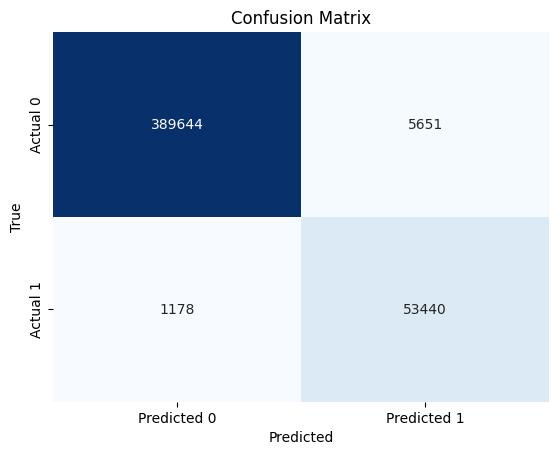

In [23]:
cm = confusion_matrix(y_gt_dataset, y_pred_dataset)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Window Creation and Preprocessing for Surrogate model Training

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dataset_normal = scaler.transform(X_dataset_normal_orig)
dataset_attack = scaler.transform(X_dataset_attack_orig)

In [25]:
windows = []


for i in range(0, len(X_train) - L + 1, S):
    window = X_train[i:i + L]
    windows.append(window)

train_windows = np.array(windows)

In [26]:
windows = []

for i in range(0, len(X_test) - L + 1, S):
    window = X_test[i:i + L]
    windows.append(window)
    
test_windows = np.array(windows)


## Surrogate Model

### Surrogate Model 1 - MLP with 2 hidden layers

In [27]:
start_time_sm1 = time.time()

In [28]:
surrogate_model = Sequential([
    Flatten(input_shape=(NUM_FEATURES, L)),      
    Dense(128, activation='relu'),    
    Dense(64, activation='relu'),     
    Dense(1)                          
])

/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-23 18:07:09.430520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9744 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [29]:
surrogate_model.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=['accuracy'])

In [30]:
surrogate_model.fit(
    train_windows, y_pred_train,
    epochs=EPOCHS,            # Number of epochs
    batch_size=32,        # Batch size
    validation_split=0.2, # Validation split
    verbose=1             # Verbosity level
)

Epoch 1/10


I0000 00:00:1745424432.079155  522708 service.cc:146] XLA service 0x704cb8004430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745424432.079182  522708 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-04-23 18:07:12.114190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-23 18:07:12.315389: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  84/8436 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9209 - loss: 0.2992 

I0000 00:00:1745424433.218298  522708 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8436/8436 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9763 - loss: 0.0788 - val_accuracy: 0.9822 - val_loss: 0.0769
Epoch 2/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9874 - loss: 0.0393 - val_accuracy: 0.9825 - val_loss: 0.0665
Epoch 3/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9885 - loss: 0.0349 - val_accuracy: 0.9830 - val_loss: 0.0697
Epoch 4/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9891 - loss: 0.0319 - val_accuracy: 0.9822 - val_loss: 0.0633
Epoch 5/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9896 - loss: 0.0298 - val_accuracy: 0.9825 - val_loss: 0.0579
Epoch 6/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9897 - loss: 0.0294 - val_accuracy: 0.9815 - val_loss: 0.0613
Epoch 7/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9899 - loss: 0.0279 - val_accuracy: 0.9813 - val_loss: 0.0654
Epoch 8/10
8436/8436 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9899 - loss: 0.0272 - val

In [31]:
logits1 = surrogate_model.predict(test_windows)
probabilities1 = tf.sigmoid(logits1).numpy()

# Convert to binary labels (0 or 1)
y_pred = (probabilities1 > 0.5).astype(int).flatten()

3516/3516 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [32]:
accuracy = accuracy_score(y_gt_test, y_pred)
recall = recall_score(y_gt_test, y_pred, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_test, y_pred, average='binary')
fidelity = accuracy_score(y_pred_test, y_pred)
print("Surrogate model 1 Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Fidelity: {fidelity:.4f}")

Surrogate model 1 Performance
Accuracy: 0.9665
Recall: 0.8890
Precision: 0.9649
Fidelity: 0.9830


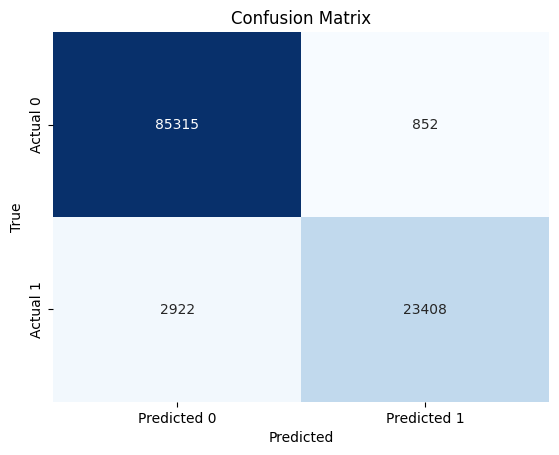

In [33]:
cm_sm1 = confusion_matrix(y_gt_test, y_pred)
sns.heatmap(cm_sm1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

selected_model = surrogate_model

In [34]:
end_time_sm1 = time.time()

print(f"Execution Time For Surrogate Model 1: {end_time_sm1 - start_time_sm1} seconds")

Execution Time For Surrogate Model 1: 272.321170091629 seconds


### Surrogate Model 2 - MLP with 4 hidden layers, regularisation and dropout

In [35]:
start_time_sm2 = time.time()

In [36]:
surrogate_model2 = Sequential([
    Flatten(input_shape=(NUM_FEATURES, L)),                     
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),                              
    Dropout(0.3),                                     
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),   
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    
    Dense(1)                   
])

/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
surrogate_model2.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fidelity_sm2 = 1

In [38]:
if (fidelity < 0.95):
    surrogate_model2.fit(
        train_windows, y_pred_train,
        epochs=EPOCHS,            # Number of epochs
        batch_size=32,        # Batch size
        validation_split=0.2, # Validation split
        verbose=1             # Verbosity level
    )

In [39]:
if fidelity<0.95:
    logits1_sm2 = surrogate_model2.predict(test_windows)
    probabilities1_sm2 = tf.sigmoid(logits1_sm2).numpy()

    y_pred_sm2 = (probabilities1_sm2 > 0.5).astype(int).flatten()



In [40]:
if fidelity<0.95:
    accuracy_sm2 = accuracy_score(y_gt_test, y_pred_sm2)
    recall_sm2 = recall_score(y_gt_test, y_pred_sm2, average='binary')  # Adjust `average` for multiclass
    precision_sm2 = precision_score(y_gt_test, y_pred_sm2, average='binary')
    fidelity_sm2 = accuracy_score(y_pred_test, y_pred_sm2)
    print("Surrogate model 2 Performance")
    print(f"Accuracy: {accuracy_sm2:.4f}")
    print(f"Recall: {recall_sm2:.4f}")
    print(f"Precision: {precision_sm2:.4f}")
    print(f"Fidelity: {fidelity_sm2:.4f}")
    selected_model = surrogate_model2


In [41]:
if fidelity<0.95:
    cm_sm2 = confusion_matrix(y_gt_test, y_pred_sm2)
    sns.heatmap(cm_sm2, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [42]:
end_time_sm2 = time.time()
if fidelity<0.95:

    print(f"Execution Time For Surrogate Model 2: {end_time_sm2 - start_time_sm2} seconds")

### Surrogate Model 3 - LSTM-based Classifier

In [43]:
start_time_sm3 = time.time()

In [44]:
fidelity_sm3 = 1
surrogate_model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(L, NUM_FEATURES)),  # LSTM layer with 64 units
    Dropout(0.3),
    LSTM(32, return_sequences=False),  # Another LSTM layer
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)  # No activation (logits output)
])


/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
surrogate_model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [46]:
if fidelity <0.95 and fidelity_sm2<0.95:
    surrogate_model3.fit(
        train_windows, y_pred_train,
        epochs=EPOCHS,            # Number of epochs
        batch_size=32,        # Batch size
        validation_split=0.2, # Validation split
        verbose=1             # Verbosity level
    )

In [47]:
if fidelity <0.95 and fidelity_sm2<0.95:
    logits1_sm3 = surrogate_model3.predict(test_windows)
    probabilities1_sm3 = tf.sigmoid(logits1_sm3).numpy()

    # Convert to binary labels (0 or 1)
    y_pred_sm3 = (probabilities1_sm3 > 0.5).astype(int).flatten()


In [48]:
if fidelity <0.95 and fidelity_sm2<0.95:
    accuracy_sm3 = accuracy_score(y_gt_test, y_pred_sm3)
    recall_sm3 = recall_score(y_gt_test, y_pred_sm3, average='binary')  # Adjust `average` for multiclass
    precision_sm3 = precision_score(y_gt_test, y_pred_sm3, average='binary')
    fidelity_sm3 = accuracy_score(y_pred_test, y_pred_sm3)
    print("Surrogate model 3 Performance")
    print(f"Accuracy: {accuracy_sm3:.4f}")
    print(f"Recall: {recall_sm3:.4f}")
    print(f"Precision: {precision_sm3:.4f}")
    print(f"Fidelity: {fidelity_sm3:.4f}")

In [49]:
if fidelity <0.95 and fidelity_sm2<0.95:
    cm_sm3 = confusion_matrix(y_gt_test, y_pred_sm3)
    sns.heatmap(cm_sm3, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    fidelities = np.array([fidelity, fidelity_sm2, fidelity_sm3])

    max_index = np.argmax(fidelities)
    models = [surrogate_model, surrogate_model2, surrogate_model3]
    selected_model = models[max_index]


In [50]:
end_time_sm3 = time.time()

print(f"Execution Time For Surrogate Model 3: {end_time_sm3 - start_time_sm3} seconds")

Execution Time For Surrogate Model 3: 0.25644707679748535 seconds


Choosing Surrogate Model based on fidelity

In [51]:
if selected_model == surrogate_model:
    print("Surrogate Model 1 is chosen.")
elif selected_model == surrogate_model2:
    print("Surrogate Model 2 is chosen.")
else:
    print("Surrogate Model 3 is chosen.")

Surrogate Model 1 is chosen.


For white-box access

In [52]:
if access == "whitebox":
    selected_model = model

# Evasion Attack Stage

In [53]:
windows = []


for i in range(0, len(dataset_normal) - L + 1, L):
    window = dataset_normal[i:i + L]
    windows.append(window)

test_windows_normal_ind = np.array(windows)

In [54]:
windows = []


for i in range(0, len(dataset_attack) - L + 1, L):
    window = dataset_attack[i:i + L]
    windows.append(window)

test_windows_attack_ind = np.array(windows)

In [55]:
y_gt_dataset_normal_ind = np.zeros(int(X_dataset_normal_orig.shape[0]/L))  
y_gt_dataset_attack_ind = np.ones(int(X_dataset_attack_orig.shape[0]/L)) 

y_gt_data = np.concatenate((np.zeros(int(X_dataset_normal_orig.shape[0]/L)*L), np.ones(int(X_dataset_attack_orig.shape[0]/L)*L)))

y_gt_dataset_ind = np.concatenate((np.zeros(int(((int(X_dataset_normal_orig.shape[0]/L))*L -L)/S + 1)), np.ones(int(((int(X_dataset_attack_orig.shape[0]/L))*L -L)/S + 1))))

## FGSM - Binary Cross Entropy

In [56]:
start_time_fgsm_bce = time.time()

In [57]:

def fgsm_attack(model, X, y, epsilon=0.1):
  
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))  

    with tf.GradientTape() as tape:
        tape.watch(X_adv)
        logits = model(X_adv)  
        loss = tf.keras.losses.binary_crossentropy(y_true, logits, from_logits=True)  

    gradient = tape.gradient(loss, X_adv)
    signed_grad = tf.sign(gradient)

    X_adv = X_adv + epsilon * signed_grad

    X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()

In [58]:
X_test_normal_adv_fgsm = fgsm_attack(selected_model, test_windows_normal_ind, y_gt_dataset_normal_ind, epsilon_normal)

In [59]:
X_test_attack_adv_fgsm = fgsm_attack(selected_model, test_windows_attack_ind, y_gt_dataset_attack_ind, epsilon_attack)


In [60]:
X_test_normal_adv_fgsm_reshaped = X_test_normal_adv_fgsm.reshape(-1, NUM_FEATURES)
X_test_attack_adv_fgsm_reshaped = X_test_attack_adv_fgsm.reshape(-1, NUM_FEATURES)


In [61]:
X_test_normal_adv_fgsm_orig = scaler.inverse_transform(X_test_normal_adv_fgsm_reshaped)
X_test_attack_adv_fgsm_orig = scaler.inverse_transform(X_test_attack_adv_fgsm_reshaped)

In [62]:
X_test_normal_adv_fgsm_orig[:, protected_cols] = np.round(X_test_normal_adv_fgsm_orig[:, protected_cols], decimals=0)
X_test_attack_adv_fgsm_orig[:, protected_cols] = np.round(X_test_attack_adv_fgsm_orig[:, protected_cols], decimals=0)

In [63]:
y_pred_normal_adv_fgsm = model.predict(X_test_normal_adv_fgsm_orig)
y_pred_attack_adv_fgsm = model.predict(X_test_attack_adv_fgsm_orig)

In [64]:
y_pred_adv_fgsm = np.concatenate((y_pred_normal_adv_fgsm, y_pred_attack_adv_fgsm))
print("FGSM-BCE Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_fgsm)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_fgsm, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_fgsm, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

FGSM-BCE Attack Performance on NIDS
Accuracy: 0.4454
Recall: 0.7098
Precision: 0.1423


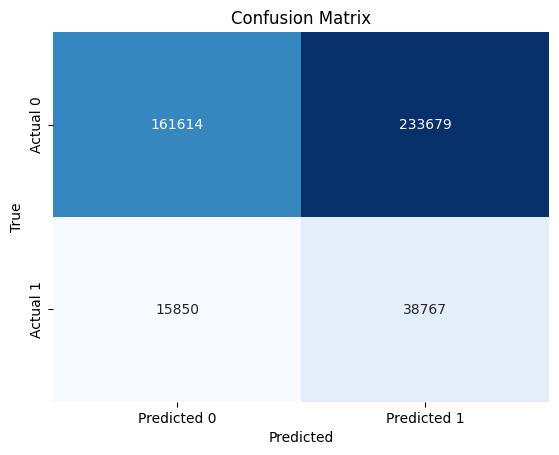

In [65]:
cm_fgsm = confusion_matrix(y_gt_dataset_ind, y_pred_adv_fgsm)
sns.heatmap(cm_fgsm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
X_test_adv_fgsm = np.concatenate((X_test_normal_adv_fgsm_orig, X_test_attack_adv_fgsm_orig))
adv_fgsm_test = np.column_stack((X_test_adv_fgsm, y_gt_data))
adv_fgsm = pd.DataFrame(adv_fgsm_test, columns=test.columns)

In [67]:
adv_fgsm.to_csv("4_rf_fgsm_swat.csv", index=False)

In [68]:
end_time_fgsm_bce = time.time()

print(f"Total Execution Time of Attack: {end_time_fgsm_bce - start_time_fgsm_bce} seconds")

Total Execution Time of Attack: 47.702399253845215 seconds


## FGSM - L0

In [69]:
start_time_fgsm0 = time.time()

In [70]:
def fgsm_attack_top_k(model, X, y, epsilon=0.1, k=50):

    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))  

    with tf.GradientTape() as tape:
        tape.watch(X_adv)
        logits = model(X_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, logits, from_logits=True)

    gradient = tape.gradient(loss, X_adv)

    abs_gradient = tf.abs(gradient)
    flat_gradients = tf.reshape(abs_gradient, [abs_gradient.shape[0], -1])

    top_k = tf.math.top_k(flat_gradients, k=k)
    top_k_indices = top_k.indices  

    mask = tf.zeros_like(flat_gradients)  

    for i in range(X_adv.shape[0]):
        indices = tf.expand_dims(top_k_indices[i], 1) 
        updates = tf.gather(tf.sign(flat_gradients[i]), top_k_indices[i]) 
        mask_i = tf.tensor_scatter_nd_update(mask[i], indices, updates)
        mask = tf.tensor_scatter_nd_update(mask, [[i]], [mask_i])

    mask = tf.reshape(mask, gradient.shape)

    X_adv = X_adv + epsilon * mask
    X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()


In [71]:
X_test_normal_adv_fgsm0 = fgsm_attack_top_k(selected_model, test_windows_normal_ind, y_gt_dataset_normal_ind, epsilon_normal, k_normal)

In [72]:
X_test_attack_adv_fgsm0 = fgsm_attack_top_k(selected_model, test_windows_attack_ind, y_gt_dataset_attack_ind, epsilon_attack, k_attack)

In [73]:
X_test_normal_adv_fgsm0_reshaped = X_test_normal_adv_fgsm0.reshape(-1, NUM_FEATURES)
X_test_attack_adv_fgsm0_reshaped = X_test_attack_adv_fgsm0.reshape(-1, NUM_FEATURES)

In [74]:
X_test_normal_adv_fgsm0_orig = scaler.inverse_transform(X_test_normal_adv_fgsm0_reshaped)
X_test_attack_adv_fgsm0_orig = scaler.inverse_transform(X_test_attack_adv_fgsm0_reshaped)

In [75]:
X_test_normal_adv_fgsm0_orig[:, protected_cols] = np.round(X_test_normal_adv_fgsm0_orig[:, protected_cols], decimals=0)
X_test_attack_adv_fgsm0_orig[:, protected_cols] = np.round(X_test_attack_adv_fgsm0_orig[:, protected_cols], decimals=0)

In [76]:
y_pred_normal_adv_fgsm0 = model.predict(X_test_normal_adv_fgsm0_orig)
y_pred_attack_adv_fgsm0 = model.predict(X_test_attack_adv_fgsm0_orig)

In [77]:
y_pred_adv_fgsm0 = np.concatenate((y_pred_normal_adv_fgsm0, y_pred_attack_adv_fgsm0))
print("FGSM-L0 Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_fgsm0)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_fgsm0, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_fgsm0, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

FGSM-L0 Attack Performance on NIDS
Accuracy: 0.8911
Recall: 0.7125
Precision: 0.5391


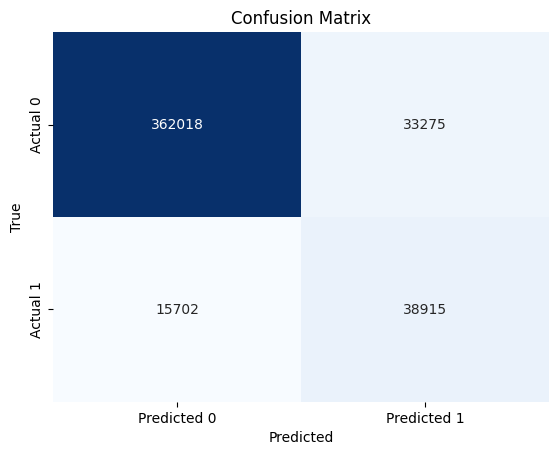

In [78]:
cm_fgsm = confusion_matrix(y_gt_dataset_ind, y_pred_adv_fgsm0)
sns.heatmap(cm_fgsm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [79]:
X_test_adv_fgsm0 = np.concatenate((X_test_normal_adv_fgsm0_orig, X_test_attack_adv_fgsm0_orig))
adv_fgsm0_test = np.column_stack((X_test_adv_fgsm0, y_gt_data))
adv_fgsm0 = pd.DataFrame(adv_fgsm0_test, columns=test.columns)

In [80]:
adv_fgsm0.to_csv("4_rf_fgsm0_swat.csv", index=False)

In [81]:
end_time_fgsm0 = time.time()

print(f"Total Execution Time of Attack: {end_time_fgsm0 - start_time_fgsm0} seconds")

Total Execution Time of Attack: 333.68728828430176 seconds


## PGD - Binary Cross Entropy Attack

In [82]:
start_time_pgd_bce = time.time()

In [83]:
def pgd_attack(model, X, y, epsilon, alpha=0.01, iterations=10, random_start=True):
    
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))  

    if random_start:
        X_adv = X_adv + tf.random.uniform(X_adv.shape, minval=-epsilon, maxval=epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1)  

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            logits = model(X_adv)  
            loss = tf.keras.losses.binary_crossentropy(y_true, logits, from_logits=True)  

        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)

        X_adv = X_adv + alpha * signed_grad

        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)

        X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()


In [84]:
X_test_normal_adv_pgd = pgd_attack(selected_model, test_windows_normal_ind, y_gt_dataset_normal_ind, epsilon_normal, alpha_normal_pgd, iterations)
X_test_attack_adv_pgd = pgd_attack(selected_model, test_windows_attack_ind, y_gt_dataset_attack_ind, epsilon_attack, alpha_attack_pgd, iterations)

In [85]:
X_test_normal_adv_pgd_reshaped = X_test_normal_adv_pgd.reshape(-1, NUM_FEATURES)
X_test_attack_adv_pgd_reshaped = X_test_attack_adv_pgd.reshape(-1, NUM_FEATURES)

In [86]:
X_test_normal_adv_pgd_orig = scaler.inverse_transform(X_test_normal_adv_pgd_reshaped)
X_test_attack_adv_pgd_orig = scaler.inverse_transform(X_test_attack_adv_pgd_reshaped)

In [87]:
X_test_normal_adv_pgd_orig[:, protected_cols] = np.round(X_test_normal_adv_pgd_orig[:, protected_cols], decimals=0)
X_test_attack_adv_pgd_orig[:, protected_cols] = np.round(X_test_attack_adv_pgd_orig[:, protected_cols], decimals=0)

In [88]:
y_pred_normal_adv_pgd = model.predict(X_test_normal_adv_pgd_orig)
y_pred_attack_adv_pgd = model.predict(X_test_attack_adv_pgd_orig)

In [89]:
y_pred_adv_pgd = np.concatenate((y_pred_normal_adv_pgd, y_pred_attack_adv_pgd))
print("PGD-BCE Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_pgd)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_pgd, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_pgd, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

PGD-BCE Attack Performance on NIDS
Accuracy: 0.6388
Recall: 0.7097
Precision: 0.2091


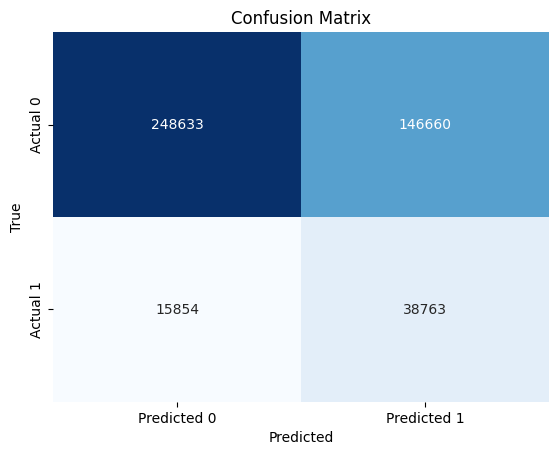

In [90]:
cm_pgd = confusion_matrix(y_gt_dataset_ind, y_pred_adv_pgd)
sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [91]:
X_test_adv_pgd = np.concatenate((X_test_normal_adv_pgd_orig, X_test_attack_adv_pgd_orig))
adv_pgd_test = np.column_stack((X_test_adv_pgd, y_gt_data))
adv_pgd = pd.DataFrame(adv_pgd_test, columns=test.columns)

In [92]:
adv_pgd.to_csv("4_rf_pgd_swat.csv", index=False)

In [93]:
end_time_pgd_bce = time.time()

print(f"Total Execution Time of Attack: {end_time_pgd_bce - start_time_pgd_bce} seconds")

Total Execution Time of Attack: 48.480371713638306 seconds


## PGD - Carlini & Wagner Loss

In [94]:
start_time_pgd_cw = time.time()

In [95]:
def cw_loss(logits, labels, confidence=0):
    
    labels = tf.cast(labels, tf.float32)
    logits = tf.reshape(logits, (-1, 1))  
    
    target_logits = (1 - labels) * logits  
    true_logits = labels * logits

    return tf.maximum(true_logits - target_logits + confidence, 0)

def pgd_attack_cw(model, X, y, epsilon=0.1, alpha=0.01, iterations=10, confidence=0, random_start=True):
    
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))  

    if random_start:
        X_adv = X_adv + tf.random.uniform(X_adv.shape, minval=-epsilon, maxval=epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            logits = model(X_adv)
            loss = cw_loss(logits, y_true, confidence)

        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)

        X_adv = X_adv + alpha * signed_grad

        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)

        X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()


In [96]:

X_test_normal_adv_pgd_cw = pgd_attack_cw(selected_model, test_windows_normal_ind, y_gt_dataset_normal_ind, epsilon_normal, alpha_normal_pgd, iterations, confidence)
X_test_attack_adv_pgd_cw = pgd_attack_cw(selected_model, test_windows_attack_ind, y_gt_dataset_attack_ind, epsilon_attack, alpha_attack_pgd, iterations, confidence)

In [97]:
X_test_normal_adv_pgd_cw_reshaped = X_test_normal_adv_pgd_cw.reshape(-1, NUM_FEATURES)
X_test_attack_adv_pgd_cw_reshaped = X_test_attack_adv_pgd_cw.reshape(-1, NUM_FEATURES)

In [98]:
X_test_normal_adv_pgd_cw_orig = scaler.inverse_transform(X_test_normal_adv_pgd_cw_reshaped)
X_test_attack_adv_pgd_cw_orig = scaler.inverse_transform(X_test_attack_adv_pgd_cw_reshaped)

In [99]:
X_test_normal_adv_pgd_cw_orig[:, protected_cols] = np.round(X_test_normal_adv_pgd_cw_orig[:, protected_cols], decimals=0)
X_test_attack_adv_pgd_cw_orig[:, protected_cols] = np.round(X_test_attack_adv_pgd_cw_orig[:, protected_cols], decimals=0)

In [100]:
y_pred_normal_adv_pgd_cw = model.predict(X_test_normal_adv_pgd_cw_orig)
y_pred_attack_adv_pgd_cw = model.predict(X_test_attack_adv_pgd_cw_orig)

In [101]:
y_pred_adv_pgd_cw = np.concatenate((y_pred_normal_adv_pgd_cw, y_pred_attack_adv_pgd_cw))
print("PGD-CW Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_pgd_cw)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_pgd_cw, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_pgd_cw, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

PGD-CW Attack Performance on NIDS
Accuracy: 0.7026
Recall: 0.7108
Precision: 0.2475


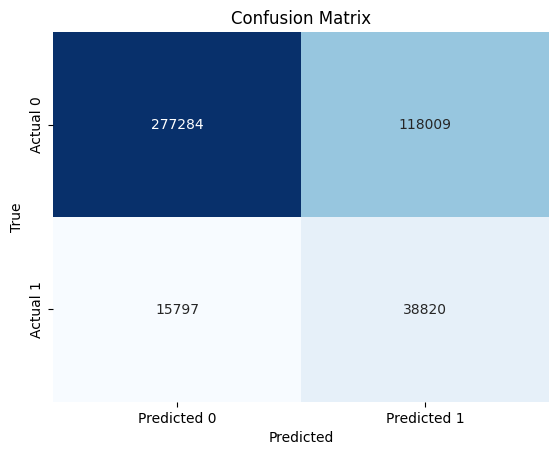

In [102]:
cm_pgd = confusion_matrix(y_gt_dataset_ind, y_pred_adv_pgd_cw)
sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [103]:
X_test_adv_pgd_cw = np.concatenate((X_test_normal_adv_pgd_cw_orig, X_test_attack_adv_pgd_cw_orig))
adv_pgd_cw_test = np.column_stack((X_test_adv_pgd_cw, y_gt_data))
adv_pgd_cw = pd.DataFrame(adv_pgd_cw_test, columns=test.columns)

In [104]:
adv_pgd_cw.to_csv("4_rf_pgd_cw_swat.csv", index=False)

In [105]:
end_time_pgd_cw = time.time()

print(f"Total Execution Time of Attack: {end_time_pgd_cw - start_time_pgd_cw} seconds")

Total Execution Time of Attack: 49.21968364715576 seconds


## PGD - Logit Attack

In [106]:
start_time_pgd_logit = time.time()

In [107]:
def pgd_attack_logit(model, X, y, epsilon=0.1, alpha=0.01, iterations=10, random_start=True):

    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    if random_start:
        X_adv = X_adv + tf.random.uniform(X_adv.shape, minval=-epsilon, maxval=epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1) 

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            logits = model(X_adv)  
            
            logit_true = tf.reduce_sum(logits * y_true, axis=1, keepdims=True)  
            logit_false = tf.reduce_max(logits * (1 - y_true), axis=1, keepdims=True)  
            
            loss = logit_false - logit_true  
            
        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)

        X_adv = X_adv + alpha * signed_grad

        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)

        X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()


In [108]:
X_test_normal_adv_pgd_logit = pgd_attack_logit(selected_model, test_windows_normal_ind, y_gt_dataset_normal_ind, epsilon_normal, alpha_normal_pgd, iterations)
X_test_attack_adv_pgd_logit = pgd_attack_logit(selected_model, test_windows_attack_ind, y_gt_dataset_attack_ind, epsilon_attack, alpha_attack_pgd, iterations)

In [109]:
X_test_normal_adv_pgd_logit_reshaped = X_test_normal_adv_pgd_logit.reshape(-1, NUM_FEATURES)
X_test_attack_adv_pgd_logit_reshaped = X_test_attack_adv_pgd_logit.reshape(-1, NUM_FEATURES)

In [110]:
X_test_normal_adv_pgd_logit_orig = scaler.inverse_transform(X_test_normal_adv_pgd_logit_reshaped)
X_test_attack_adv_pgd_logit_orig = scaler.inverse_transform(X_test_attack_adv_pgd_logit_reshaped)

In [111]:
X_test_normal_adv_pgd_logit_orig[:, protected_cols] = np.round(X_test_normal_adv_pgd_logit_orig[:, protected_cols], decimals=0)
X_test_attack_adv_pgd_logit_orig[:, protected_cols] = np.round(X_test_attack_adv_pgd_logit_orig[:, protected_cols], decimals=0)

In [112]:
y_pred_normal_adv_pgd_logit = model.predict(X_test_normal_adv_pgd_logit_orig)
y_pred_attack_adv_pgd_logit = model.predict(X_test_attack_adv_pgd_logit_orig)

In [113]:
y_pred_adv_pgd_logit = np.concatenate((y_pred_normal_adv_pgd_logit, y_pred_attack_adv_pgd_logit))

print("PGD-logit Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_pgd_logit)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_pgd_logit, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_pgd_logit, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

PGD-logit Attack Performance on NIDS
Accuracy: 0.6401
Recall: 0.7096
Precision: 0.2097


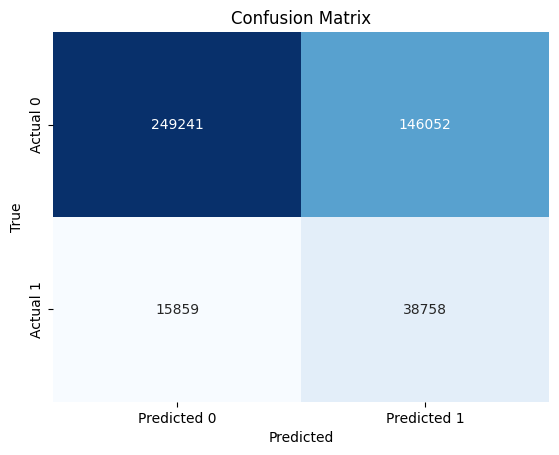

In [114]:
cm_pgd = confusion_matrix(y_gt_dataset_ind, y_pred_adv_pgd_logit)
sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [115]:
X_test_adv_pgd_logit = np.concatenate((X_test_normal_adv_pgd_logit_orig, X_test_attack_adv_pgd_logit_orig))
adv_pgd_logit_test = np.column_stack((X_test_adv_pgd_logit, y_gt_data))
adv_pgd_logit = pd.DataFrame(adv_pgd_logit_test, columns=test.columns)

In [116]:
adv_pgd_logit.to_csv("4_rf_pgd_logit_swat.csv", index=False)

In [117]:
end_time_pgd_logit = time.time()

print(f"Total Execution Time of Attack: {end_time_pgd_logit - start_time_pgd_logit} seconds")

Total Execution Time of Attack: 47.84676265716553 seconds


## PGD-KL Divergence Attack

In [118]:
start_time_pgd_kl = time.time()

In [119]:
def pgd_attack_kl(model, X, epsilon=0.1, alpha=0.01, iterations=10, random_start=True):

    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)

    original_logits = model(X_adv)  
    original_probs = tf.nn.sigmoid(original_logits) 
    original_probs = tf.concat([1 - original_probs, original_probs], axis=1)  

    if random_start:
        X_adv = X_adv + tf.random.uniform(X_adv.shape, minval=-epsilon, maxval=epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1)  

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            perturbed_logits = model(X_adv)  
            perturbed_probs = tf.nn.sigmoid(perturbed_logits)  
            perturbed_probs = tf.concat([1 - perturbed_probs, perturbed_probs], axis=1) 

            loss = tf.keras.losses.KLDivergence()(original_probs, perturbed_probs)

        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)

        X_adv = X_adv + alpha * signed_grad

        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)

        X_adv = tf.clip_by_value(X_adv, 0, 1)

    return X_adv.numpy()


In [120]:

X_test_normal_adv_pgd_kl = pgd_attack_kl(selected_model, test_windows_normal_ind, epsilon_normal, alpha_normal_pgd, iterations)
X_test_attack_adv_pgd_kl = pgd_attack_kl(selected_model, test_windows_attack_ind, epsilon_attack, alpha_attack_pgd, iterations)

In [121]:
X_test_normal_adv_pgd_kl_reshaped = X_test_normal_adv_pgd_kl.reshape(-1, NUM_FEATURES)
X_test_attack_adv_pgd_kl_reshaped = X_test_attack_adv_pgd_kl.reshape(-1, NUM_FEATURES)

In [122]:
X_test_normal_adv_pgd_kl_orig = scaler.inverse_transform(X_test_normal_adv_pgd_kl_reshaped)
X_test_attack_adv_pgd_kl_orig = scaler.inverse_transform(X_test_attack_adv_pgd_kl_reshaped)

In [123]:
X_test_normal_adv_pgd_kl_orig[:, protected_cols] = np.round(X_test_normal_adv_pgd_kl_orig[:, protected_cols], decimals=0)
X_test_attack_adv_pgd_kl_orig[:, protected_cols] = np.round(X_test_attack_adv_pgd_kl_orig[:, protected_cols], decimals=0)

In [124]:
y_pred_normal_adv_pgd_kl = model.predict(X_test_normal_adv_pgd_kl_orig)
y_pred_attack_adv_pgd_kl = model.predict(X_test_attack_adv_pgd_kl_orig)

In [125]:
y_pred_adv_pgd_kl = np.concatenate((y_pred_normal_adv_pgd_kl, y_pred_attack_adv_pgd_kl))
print("PGD-KL Div Attack Performance on NIDS")
accuracy = accuracy_score(y_gt_dataset_ind, y_pred_adv_pgd_kl)
recall = recall_score(y_gt_dataset_ind, y_pred_adv_pgd_kl, average='binary')  # Adjust `average` for multiclass
precision = precision_score(y_gt_dataset_ind, y_pred_adv_pgd_kl, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

PGD-KL Div Attack Performance on NIDS
Accuracy: 0.6311
Recall: 0.7111
Precision: 0.2055


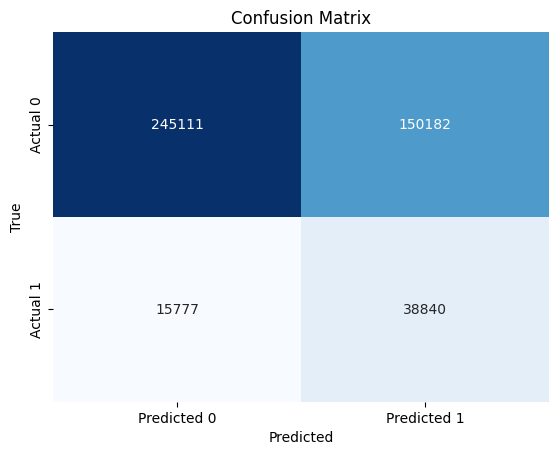

In [126]:
cm_pgd = confusion_matrix(y_gt_dataset_ind, y_pred_adv_pgd_kl)
sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [127]:
X_test_adv_pgd_kl = np.concatenate((X_test_normal_adv_pgd_kl_orig, X_test_attack_adv_pgd_kl_orig))
adv_pgd_kl_test = np.column_stack((X_test_adv_pgd_kl, y_gt_data))
adv_pgd_kl = pd.DataFrame(adv_pgd_kl_test, columns=test.columns)

In [128]:
adv_pgd_kl.to_csv("4_rf_pgd_kl_swat.csv", index=False)

In [129]:
end_time_pgd_kl = time.time()
print(f"Total Execution Time of Attack: {end_time_pgd_kl - start_time_pgd_kl} seconds")

Total Execution Time of Attack: 48.316643714904785 seconds


## CorrShift Attack (Correlation-Driven Feature Shift Attack)

In [130]:
start_time_sq = time.time()

In [131]:
class AdversarialExampleGenerator:
    def __init__(self, model, alpha):
        self.model = model  
        self.alpha = alpha 
        self.epsilon = None  

    def compute_featurewise_epsilon(self, X):
        
        max_values = np.max(np.abs(X), axis=(0, 1))  
        min_values = np.min(np.abs(X), axis=(0, 1))  
        self.epsilon = self.alpha * (max_values - min_values) 

    def apply_perturbation(self, X, y, protected_cols):
        
        num_samples, num_rows, num_features = X.shape

        self.compute_featurewise_epsilon(X)

        non_protected_cols = [i for i in range(num_features) if i not in protected_cols]


        flattened_data = X.reshape(-1, num_features)  
        corr_matrix = np.corrcoef(flattened_data, rowvar=False)  

        max_diff = -1
        best_adv_examples = None

        all_adv_examples = np.zeros_like(X)

        for sample_idx in range(num_samples):
            original_sample = X[sample_idx].copy() 

            for i, candidate_feature in enumerate(non_protected_cols):
                adv_example = original_sample.copy() 

                for j, feature in enumerate(non_protected_cols):
                    epsilon_j = self.epsilon[feature]
                    
                    if j == i:
                        adv_example[:, feature] += epsilon_j


                    if corr_matrix[i, j] < 0:
                        adv_example[:, feature] -= epsilon_j
                    else:
                        adv_example[:, feature] += epsilon_j

                predictions = self.model.predict(adv_example) 

                diff_count = np.sum(predictions != y[sample_idx])  

                if diff_count > max_diff:
                    max_diff = diff_count
                    best_adv_examples = adv_example

            all_adv_examples[sample_idx] = best_adv_examples

        return all_adv_examples 


In [132]:
num_windows1 = len(X_dataset_normal_orig) // TIMESTEPS  
X_test_windows1 = np.array([X_dataset_normal_orig[i * TIMESTEPS:(i + 1) * TIMESTEPS] for i in range(num_windows1)])

num_windows2 = len(X_dataset_attack_orig) // TIMESTEPS  
X_test_windows2 = np.array([X_dataset_attack_orig[i * TIMESTEPS:(i + 1) * TIMESTEPS] for i in range(num_windows2)])

In [133]:
M_dim = int((TIMESTEPS - L)/S + 1)

y_test1 = np.zeros((num_windows1, M_dim))
y_test2 = np.ones((num_windows2, M_dim))

In [134]:
patch_perturbation1 = AdversarialExampleGenerator(model=model, alpha=alpha_bb_normal)

perturbed_data1 = patch_perturbation1.apply_perturbation(
    X_test_windows1,
    y_test1,
    protected_cols  
)

/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [135]:
patch_perturbation2 = AdversarialExampleGenerator(model=model, alpha=alpha_bb_attack)

perturbed_data2 = patch_perturbation2.apply_perturbation(
    X_test_windows2,
    y_test2,
    protected_cols  
)

/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/advmlstudent/Documents/benchmark/ics-nids-robustness-benchmark/myenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [136]:
original_shape1 = X_test_windows1.shape[0] * X_test_windows1.shape[1], X_test_windows1.shape[2]
X_adv_bb1 = perturbed_data1.reshape(original_shape1)
y_bb_1 = np.zeros(int((original_shape1[0]-L)/S + 1))
y1 = np.zeros(original_shape1[0])

original_shape2 = X_test_windows2.shape[0] * X_test_windows2.shape[1], X_test_windows2.shape[2]
X_adv_bb2 = perturbed_data2.reshape(original_shape2)
y_bb_2 = np.ones(int((original_shape2[0]-L)/S + 1))
y2 = np.ones(original_shape2[0])

In [137]:
y_pred_bb_normal = model.predict(X_adv_bb1)
y_pred_bb_attack = model.predict(X_adv_bb2)

In [138]:
y_pred_bb = np.concatenate((y_pred_bb_normal, y_pred_bb_attack))
y_gt = np.concatenate((y_bb_1, y_bb_2))
print("CorrShift Attack Performance on NIDS")
accuracy = accuracy_score(y_gt, y_pred_bb)
recall = recall_score(y_gt, y_pred_bb, average='binary') 
precision = precision_score(y_gt, y_pred_bb, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

CorrShift Attack Performance on NIDS
Accuracy: 0.0000
Recall: 0.0000
Precision: 0.0000


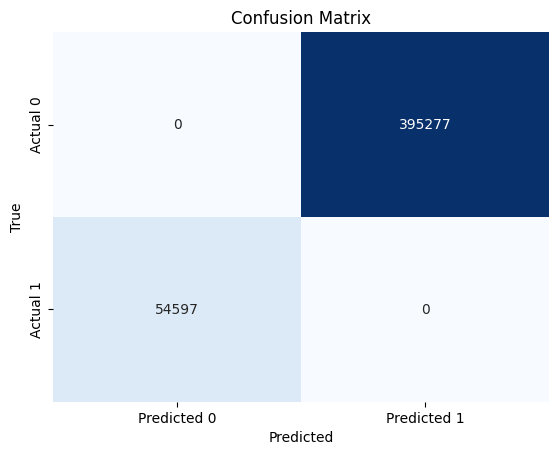

In [139]:
cm_bb = confusion_matrix(y_gt, y_pred_bb)
sns.heatmap(cm_bb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [140]:
X_test_adv_corr = np.concatenate((X_adv_bb1, X_adv_bb2))
y_corr = np.concatenate((y1, y2))
adv_corr_test = np.column_stack((X_test_adv_corr, y_corr))
adv_corr = pd.DataFrame(adv_corr_test, columns=test.columns)

In [141]:
adv_corr.to_csv("4_rf_corr_swat.csv", index=False)

In [142]:
end_time_sq = time.time()
print(f"Total Execution Time of Attack: {end_time_sq - start_time_sq} seconds")

Total Execution Time of Attack: 1542.886509180069 seconds


In [143]:
end_time = time.time()

print(f"Total Execution Time of Framework: {end_time - start_time} seconds")

Total Execution Time of Framework: 2477.5686519145966 seconds
